In [12]:
import numpy as np
import os
import pandas as pd
import scipy.interpolate
import sklearn.metrics
import sys
sys.path.append("../src")
import localmodule


from matplotlib import pyplot as plt
%matplotlib inline

# Define constants.
n_eval_trials = 1
dataset_name = localmodule.get_dataset_name()
models_dir = localmodule.get_models_dir()
units = localmodule.get_units()
n_units = len(units)
n_thresholds = 221
n_trial_groups = int(np.floor(10 / n_eval_trials))
n_trials = n_trial_groups * n_eval_trials


# Initialize dicts.
report = {}


model_names = [
    "icassp-convnet",
    "icassp-convnet_aug-all",
    "pcen-convnet",
    "pcen-convnet_aug-all",
    "pcen-add-convnet",
    "pcen-add-convnet_aug-all-but-noise",
]

# Loop over augmentations.
for model_name in model_names:

    # Initialize dictionaries
    aug_report = {
        "test-CV-AUPRC": {},
        "test-CV-F": {},
        "val-AUPRC": {},
        "val-F": {},
    }

    ###############################   VALIDATION   #################################
    val_precisions = np.zeros((n_units, n_trials))
    val_recalls = np.zeros((n_units, n_trials))
    val_f1_scores = np.zeros((n_units, n_trials))
    val_auprcs = np.zeros((n_units, n_trials))
    val_thresholds = np.zeros((n_units, n_trials))
    val_threshold_ids = np.zeros((n_units, n_trials))


    thresholds = 1.0 - np.concatenate((
        np.logspace(-9, -2, 141), np.delete(np.logspace(-2, 0, 81), 0)
    ))
    n_thresholds = len(thresholds)


    # Define model directory
    model_dir = os.path.join(models_dir, model_name)


    # Loop over test units.
    for test_unit_id in range(n_units):

        test_unit_str = units[test_unit_id]
        test_unit_dir = os.path.join(model_dir, test_unit_str)

        # Retrieve fold such that unit_str is in the test set.
        folds = localmodule.fold_units()
        fold = [f for f in folds if test_unit_str in f[0]][0]
        test_units = fold[0]
        validation_units = fold[2]

        # Loop over trials.
        for trial_id in range(n_trials):

            trial_str = "trial-" + str(trial_id)
            trial_dir = os.path.join(test_unit_dir, trial_str)
            break_switch = False

            # Loop over validation units.
            for predict_unit_str in validation_units:
                val_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + predict_unit_str,
                    "full-audio-metrics.csv"
                ])
                val_metrics_path = os.path.join(trial_dir, val_metrics_name)
                val_tp = np.zeros((n_thresholds,))
                val_fp = np.zeros((n_thresholds,))
                val_fn = np.zeros((n_thresholds,))
                try:
                    val_metrics_df = pd.read_csv(val_metrics_path)
                    val_tp = val_tp + np.array(val_metrics_df["True positives"])
                    val_fp = val_fp + np.array(val_metrics_df["False positives"])
                    val_fn = val_fn + np.array(val_metrics_df["False negatives"])
                except:
                    break_switch = True
                    break

            if break_switch:
                val_auprc = 0.0
                val_p = np.zeros((n_thresholds,))
                val_r = np.zeros((n_thresholds,))
                val_f = np.zeros((n_thresholds,))
                val_threshold_id = 0
                val_auprc = 0.0
            else:
                val_p = val_tp / (np.finfo(float).eps + val_tp + val_fp)
                val_r = val_tp / (np.finfo(float).eps + val_tp + val_fn)
                val_f = 2*val_p*val_r / (np.finfo(float).eps+(val_p+val_r))
                val_threshold_id = np.argmax(val_f)
                val_p_ = np.array([1.0] + list(val_p) + [0.0])
                val_r_ = np.array([0.0] + list(val_r) + [1.0])
                val_auprc = sklearn.metrics.auc(val_r_, val_p_, reorder=True)

            val_precisions[test_unit_id, trial_id] = val_p[val_threshold_id]
            val_recalls[test_unit_id, trial_id] = val_r[val_threshold_id]
            val_f1_scores[test_unit_id, trial_id] = val_f[val_threshold_id]
            val_thresholds[test_unit_id, trial_id] = thresholds[val_threshold_id]
            val_threshold_ids[test_unit_id, trial_id] = val_threshold_id
            val_auprcs[test_unit_id, trial_id] = val_auprc


    val_F_tensor = np.reshape(val_f1_scores, (6, n_eval_trials, n_trial_groups))
    val_F_trials = np.zeros((6, n_eval_trials))
    val_F_precisions = np.zeros((6, n_eval_trials))
    val_F_recalls = np.zeros((6, n_eval_trials))
    val_F_f1_scores = np.zeros((6, n_eval_trials))
    val_F_thresholds = np.zeros((6, n_eval_trials))
    val_F_threshold_ids = np.zeros((6, n_eval_trials))
    val_F_auprcs = np.zeros((6, n_eval_trials))


    val_AUPRC_tensor = np.reshape(val_auprcs, (6, n_eval_trials, n_trial_groups))
    val_AUPRC_trials = np.zeros((6, n_eval_trials))
    val_AUPRC_precisions = np.zeros((6, n_eval_trials))
    val_AUPRC_recalls = np.zeros((6, n_eval_trials))
    val_AUPRC_f1_scores = np.zeros((6, n_eval_trials))
    val_AUPRC_thresholds = np.zeros((6, n_eval_trials))
    val_AUPRC_threshold_ids = np.zeros((6, n_eval_trials))
    val_AUPRC_auprcs = np.zeros((6, n_eval_trials))


    # Select best n INDEPENDENT trials out of 10.
    # We proceed by groups to guarantee statistical independence.
    # Loop over test units.
    for test_unit_id in range(6):

        # Loop over trials.
        for eval_trial_id in range(n_eval_trials):

            best_F_column_id = np.argmax(
                val_F_tensor[test_unit_id, eval_trial_id, :])
            trial_F_id = n_trial_groups * eval_trial_id + best_F_column_id
            
            val_F_precisions[test_unit_id, eval_trial_id] =\
                val_precisions[test_unit_id, trial_F_id]
            val_F_recalls[test_unit_id, eval_trial_id] =\
                val_recalls[test_unit_id, trial_F_id]
            val_F_f1_scores[test_unit_id, eval_trial_id] =\
                val_f1_scores[test_unit_id, trial_F_id]
            val_F_trials[test_unit_id, eval_trial_id] =\
                trial_F_id
            val_F_thresholds[test_unit_id, eval_trial_id] =\
                val_thresholds[test_unit_id, trial_F_id]
            val_F_threshold_ids[test_unit_id, eval_trial_id] =\
                val_threshold_ids[test_unit_id, trial_F_id]
            val_F_auprcs[test_unit_id, eval_trial_id] =\
                val_auprcs[test_unit_id, trial_F_id]

            best_AUPRC_column_id = np.argmax(
                val_AUPRC_tensor[test_unit_id, eval_trial_id, :])
            trial_AUPRC_id = n_trial_groups * eval_trial_id + best_AUPRC_column_id
            
            val_AUPRC_precisions[test_unit_id, eval_trial_id] =\
                val_precisions[test_unit_id, trial_AUPRC_id]
            val_AUPRC_recalls[test_unit_id, eval_trial_id] =\
                val_recalls[test_unit_id, trial_AUPRC_id]
            val_AUPRC_f1_scores[test_unit_id, eval_trial_id] =\
                val_f1_scores[test_unit_id, trial_AUPRC_id]
            val_AUPRC_trials[test_unit_id, eval_trial_id] =\
                trial_AUPRC_id
            val_AUPRC_thresholds[test_unit_id, eval_trial_id] =\
                val_thresholds[test_unit_id, trial_AUPRC_id]
            val_AUPRC_threshold_ids[test_unit_id, eval_trial_id] =\
                val_threshold_ids[test_unit_id, trial_AUPRC_id]
            val_AUPRC_auprcs[test_unit_id, eval_trial_id] =\
                val_auprcs[test_unit_id, trial_AUPRC_id]


    aug_report["val-F"] = {
        "P": val_F_precisions,
        "R": val_F_recalls,
        "F": val_F_f1_scores,
        "trials": val_F_trials,
        "thresholds": val_F_thresholds,
        "threshold_ids": val_F_threshold_ids,
        "AUPRC": val_F_auprcs
    }


    aug_report["val-AUPRC"] = {
        "P": val_AUPRC_precisions,
        "R": val_AUPRC_recalls,
        "F": val_AUPRC_f1_scores,
        "trials": val_AUPRC_trials,
        "thresholds": val_AUPRC_thresholds,
        "threshold_ids": val_AUPRC_threshold_ids,
        "AUPRC": val_AUPRC_auprcs
    }


    ###############################   TEST   #################################

    for mode in ["F", "AUPRC"]:
        val_mode = "val-" + mode
        test_mode = "test-CV-" + mode

        aug_report[test_mode] = {
            "CV-P": np.zeros((n_eval_trials,)),
            "CV-R": np.zeros((n_eval_trials,)),
            "CV-F": np.zeros((n_eval_trials,)),
            "CV-AUPRC": np.zeros((n_eval_trials,)),
            "P": np.zeros((n_thresholds, n_eval_trials)),
            "R": np.zeros((n_thresholds, n_eval_trials)),
            "F": np.zeros((n_thresholds, n_eval_trials))
        }

        # Loop over trials.
        for eval_trial_id in range(n_eval_trials):
            break_switch = False

            test_tp = np.zeros((n_thresholds,))
            test_fp = np.zeros((n_thresholds,))
            test_fn = np.zeros((n_thresholds,))

            for test_unit_id in range(n_units):

                test_unit_str = units[test_unit_id]
                test_unit_dir = os.path.join(model_dir, test_unit_str)

                trial_id = int(aug_report[
                    val_mode]["trials"][test_unit_id, eval_trial_id])
                trial_str = "trial-" + str(trial_id)
                trial_dir = os.path.join(test_unit_dir, trial_str)

                # Load test predictions.
                test_metrics_name = "_".join([
                    dataset_name,
                    model_name,
                    "test-" + test_unit_str,
                    trial_str,
                    "predict-" + test_unit_str,
                    "full-audio-metrics.csv"
                ])
                test_metrics_path = os.path.join(trial_dir, test_metrics_name)
                try:
                    test_metrics_df = pd.read_csv(test_metrics_path)
                    test_tp = test_tp + np.array(test_metrics_df["True positives"])
                    test_fp = test_fp + np.array(test_metrics_df["False positives"])
                    test_fn = test_fn + np.array(test_metrics_df["False negatives"])
                except:
                    print(test_metrics_name)
                    break_switch = True


            if break_switch:
                test_auprc = 0.0
                test_p = np.zeros((n_thresholds,))
                test_r = np.zeros((n_thresholds,))
                test_f = np.zeros((n_thresholds,))
                test_threshold = 1.0
                test_threshold_id = 0
                test_auprc = 0.0
            else:
                test_p = test_tp / (np.finfo(float).eps + test_tp + test_fp)
                test_r = test_tp / (np.finfo(float).eps + test_tp + test_fn)
                test_f = 2*test_p*test_r / (np.finfo(float).eps+(test_p+test_r))
                test_threshold = aug_report[
                    val_mode]["thresholds"][test_unit_id, eval_trial_id]
                test_threshold_id = int(aug_report[
                    val_mode]["threshold_ids"][test_unit_id, eval_trial_id])
                test_p_ = np.array([1.0] + list(test_p) + [0.0])
                test_r_ = np.array([0.0] + list(test_r) + [1.0])
                test_auprc = sklearn.metrics.auc(test_r_, test_p_, reorder=True)



            aug_report[test_mode]["CV-P"][eval_trial_id] = test_p[test_threshold_id]
            aug_report[test_mode]["CV-R"][eval_trial_id] = test_r[test_threshold_id]
            aug_report[test_mode]["CV-F"][eval_trial_id] = test_f[test_threshold_id]
            aug_report[test_mode]["CV-AUPRC"][eval_trial_id] = test_auprc


            aug_report[test_mode]["P"][:, eval_trial_id] = test_p
            aug_report[test_mode]["R"][:, eval_trial_id] = test_r
            aug_report[test_mode]["F"][:, eval_trial_id] = test_f
            

        all_test_recalls = np.array(list(np.sort(np.ravel(aug_report[test_mode]["R"]))))
        interpolated_precisions = np.zeros((2 + len(all_test_recalls), n_eval_trials))

        for eval_trial_id in range(n_eval_trials):
            precision_interpolator = scipy.interpolate.interp1d(
                np.array([0.0] + list(aug_report[test_mode]["R"][:, eval_trial_id]) + [1.0]),
                np.array([1.0] + list(aug_report[test_mode]["P"][:, eval_trial_id]) + [0.0]))
            interpolated_precisions[:, eval_trial_id] =\
                np.array([1.0] + list(precision_interpolator(all_test_recalls)) + [0.0])

        interpolated_recalls = np.array([0.0] + list(all_test_recalls) + [1.0])
        aug_report[test_mode]["interpolated_P"] = np.sort(interpolated_precisions, axis=1)
        aug_report[test_mode]["interpolated_R"] = interpolated_recalls
        aug_report[test_mode]["interpolated_F"] =\
            (2*aug_report[test_mode]["interpolated_P"]*aug_report[test_mode]["interpolated_R"][:, np.newaxis]) /\
            (np.finfo(float).eps+aug_report[test_mode]["interpolated_P"]+aug_report[test_mode]["interpolated_R"][:, np.newaxis])
            

    report[model_name] = aug_report

In [53]:
model_color = "#FFFFFF"
'#%02x%02x%02x' % tuple((128 + hex2rgb(model_color)/2).astype('int'))
#rgb2hex(hex2rgb(model_color)).astype('int')

'#ffffff'

X
X
s
s
o
o


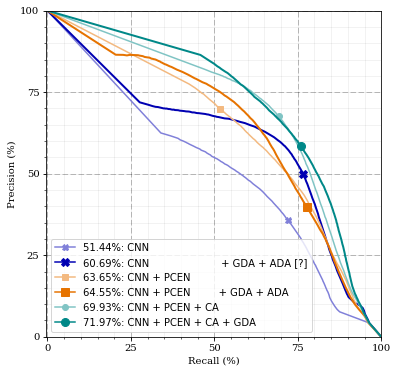

In [73]:
import matplotlib
from matplotlib import pyplot as plt

sorted_precisions = np.sort(interpolated_precisions, axis=1)


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

def hex2rgb(h):
    rgb = np.array([int(h[i:i+2], 16) for i in (1, 3 ,5)])
    return rgb

def rgb2hex(rgb):
    return '#%02x%02x%02x' % tuple(rgb)

model_colors = {
    "icassp-convnet": "#0000B2", 
    "icassp-convnet_aug-all": "#0000B2", 
    "pcen-convnet": "#E67300",
    "pcen-convnet_aug-all": "#E67300",
    "pcen-add-convnet": "#008888",
    "pcen-add-convnet_aug-all-but-noise": "#008888",
    #"#0000B2",
    #"#009900",
    #'#008888',
    #'#888800',
    #'#555555',
}
model_names = list(report.keys())
model_legends = []

model_captions = {
    "icassp-convnet": "CNN",
    "icassp-convnet_aug-all": "CNN                       + GDA + ADA [?]",
    "pcen-convnet": "CNN + PCEN",
    "pcen-convnet_aug-all": "CNN + PCEN         + GDA + ADA",
    "pcen-add-convnet": "CNN + PCEN + CA",
    "pcen-add-convnet_aug-all-but-noise": "CNN + PCEN + CA + GDA",
}

eval_mode = "test-CV-F"



for model_id, model_name in enumerate(model_names):
    
    model_color = model_colors[model_name]
    
    
    if "aug" in model_name:
        line_width = 2.0
        marker_size = 8.0
    else:
        model_color = rgb2hex((128 + hex2rgb(model_color) / 2).astype('int'))
        line_width = 1.5
        marker_size = 6.0
        
    
    if "icassp-convnet" in model_name:
        marker = "X"
    if "pcen-convnet" in model_name:
        marker = "s"
    elif "pcen-add-convnet" in model_name:
        marker = "o"
        
    print(marker)

    ax.plot(
        100 * report[model_name][eval_mode]["interpolated_R"],
        100 * np.percentile(report[model_name][eval_mode]["interpolated_P"], 50, axis=1),
        color = model_color,
        linewidth = line_width
    )
    
    cv_p = np.mean(report[model_name][eval_mode]["CV-P"])
    cv_r = np.mean(report[model_name][eval_mode]["CV-R"])
    cv_f = np.mean(report[model_name][eval_mode]["CV-F"])
    cv_auprc = np.mean(report[model_name][eval_mode]["CV-AUPRC"])
    
    plot_r = [100*cv_r]
    plot_p = [100*cv_p]
    plot_f = 100*cv_f
    plot_auprc = 100 * cv_auprc
    
    ax.plot(plot_r, plot_p, marker, 
            color = model_color,
            markersize = marker_size)
    
    model_legend = matplotlib.lines.Line2D([], [],
        color = model_color,
        marker = marker,
        markersize = marker_size,
        label = "{:5.2f}%: ".format(plot_auprc) + model_captions[model_name])
    
    model_legends.append(model_legend)

    
plt.legend(handles = model_legends)
    
    
############################### AXES AND GRID ###################################

major_ticks = np.linspace(0, 100, 5).astype("int")
minor_ticks = np.linspace(0, 100, 21).astype("int")

ax.set_xlim(-0.3, 100)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor = True)
ax.set_xticklabels(map(str, major_ticks), family="serif");
ax.set_xlabel("Recall (%)", family = "serif");

ax.set_ylim(0.0, 100)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_yticklabels(map(str, major_ticks), family="serif");
ax.set_ylabel("Precision (%)", family="serif");

ax.grid(color='k', linestyle='--', linewidth=1.0, alpha=0.25, which="major")
ax.grid(color='k', linestyle='-', linewidth=0.5, alpha=0.1, which="minor")
ax.set_axisbelow(True)

plt.savefig("spl_fig_precision-recall.png", dpi=500)


In [24]:
import webcolors

ModuleNotFoundError: No module named 'webcolors'

In [39]:
for val_mode in ["val-AUPRC", "val-F"]:

    Ps = ["{:5.2f}%".format(100*np.mean(report[x][val_mode]["P"])) for x in report]
    Rs = ["{:5.2f}%".format(100*np.mean(report[x][val_mode]["R"])) for x in report]
    F1s = ["{:5.2f}%".format(100*np.mean(report[x][val_mode]["F"])) for x in report]
    AUCs = ["{:5.2f}%".format(100*np.mean(report[x][val_mode]["AUPRC"])) for x in report]
    metrics = [Ps, Rs, F1s, AUCs]

    import pandas as pd
    print("#########   " + val_mode + "   #################################################")
    print(pd.DataFrame([Ps, Rs, F1s, AUCs], columns=model_names,
        index=["Precision", "Recall", "F1 score", "AUPRC"]).T)
    print("")
    print("")

print("")
print("")

for test_mode in ["test-CV-AUPRC", "test-CV-F"]:

    Ps = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-P"])) for x in report]
    Rs = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-R"])) for x in report]
    F1s = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-F"])) for x in report]
    AUCs = ["{:5.2f}%".format(100*np.mean(report[x][test_mode]["CV-AUPRC"])) for x in report]
    metrics = [Ps, Rs, F1s, AUCs]

    import pandas as pd
    print("#########   " + test_mode + "   #################################################")
    print(pd.DataFrame([Ps, Rs, F1s, AUCs], columns=model_names,
        index=["Precision", "Recall", "F1 score", "AUPRC"]).T)
    print("")
    print("")

#########   val-AUPRC   #################################################
                                   Precision  Recall F1 score   AUPRC
icassp-convnet                        59.94%  64.56%   60.28%  62.32%
pcen-convnet                          73.22%  66.72%   69.75%  72.39%
pcen-add-convnet                      74.72%  67.71%   70.95%  74.31%
pcen-add-convnet_aug-all-but-noise    80.32%  69.75%   74.58%  78.62%
icassp-convnet_aug-all                66.53%  70.25%   67.09%  70.64%


#########   val-F   #################################################
                                   Precision  Recall F1 score   AUPRC
icassp-convnet                        61.31%  64.89%   61.29%  61.12%
pcen-convnet                          73.23%  67.50%   70.19%  72.24%
pcen-add-convnet                      76.17%  68.03%   71.78%  74.30%
pcen-add-convnet_aug-all-but-noise    80.32%  69.75%   74.58%  78.62%
icassp-convnet_aug-all                67.52%  70.47%   67.62%  69.00%




######### 

In [36]:
report["pcen-add-convnet_aug-all-but-noise"]["val-F"]["AUPRC"]

array([[ 0.78227156],
       [ 0.76748361],
       [ 0.76475629],
       [ 0.77366064],
       [ 0.75724878],
       [ 0.87205775]])

In [40]:
2+2

4